In [1]:
from langchain_openai import ChatOpenAI
from langchain_anthropic import ChatAnthropic

import os
import getpass
os.environ['OPENAI_API_KEY'] = ""
os.environ['ANTHROPIC_API_KEY'] = ""

In [2]:
def add(a: int, b: int):
    """Adds two numbers"""
    return a + b

In [3]:
def multiply(a: int, b: int):
    """Multiplies two numbers"""
    return a * b

### Wrapper for a single agent that can both call tools and transfer to other agents

In [4]:
from langgraph.prebuilt import create_react_agent

In [5]:
model = ChatOpenAI(model="gpt-4o")

In [6]:
model_anthropic = ChatAnthropic(model="claude-3-5-sonnet-latest")

In [7]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, GraphCommand, START, END
from typing import Literal

In [8]:
from langchain_core.runnables import RunnableConfig

In [9]:
from langchain_core.messages import HumanMessage

In [10]:
from typing import Callable

In [11]:
# output processors

def keep_last_message_as_human(state, agent_name):
    updated_state = state.copy()
    last_message_content = updated_state["messages"][-1].content
    last_message = HumanMessage(content=last_message_content, name=agent_name)
    updated_state["messages"] = [last_message]
    return updated_state

---

### Implement transfer tools with graph command + parent

In [12]:
from langchain_core.tools import tool
from langgraph.graph import GraphCommand

In [13]:
from typing import Literal

In [14]:
from langchain_core.messages import ToolMessage, AIMessage

In [15]:
@tool#(return_direct=True)
def transfer_to_bob() -> GraphCommand[Literal["bob"]]:
    """Transfer to Bob"""
    return GraphCommand(
        # NOTE: this style of message is actually unnecessary for transfers, as react agent will break out directly
        # update={"messages": [ToolMessage(content="Transfered to Bob", tool_call_id="")]},
        update={"node": "bob"},
	    goto="bob",
        graph=GraphCommand.PARENT
    )


@tool(return_direct=True)
def transfer_to_alice() -> GraphCommand[Literal["alice"]]:
    """Transfer to Alice"""
    return GraphCommand(
        update={"node": "alice"},
	    goto="alice",
        graph=GraphCommand.PARENT
    )


@tool(return_direct=True)
def transfer_to_charlie() -> GraphCommand[Literal["charlie"]]:
    """Transfer to Charlie"""
    return GraphCommand(
        update={"node": "charlie"},
        goto="charlie",
        graph=GraphCommand.PARENT
    )

In [16]:
from langgraph.prebuilt import ToolNode

In [17]:
tool_node = ToolNode([transfer_to_bob, add])

In [18]:
bob_tool_call = {"args": {}, "id": "1", "name": "transfer_to_bob"}
add_tool_call = {"args": {"a": 1, "b": 2}, "id": "1", "name": "add"}
msg = AIMessage("", tool_calls=[bob_tool_call])

tool_node.invoke({"messages": [msg]})

Command(graph='__parent__', update={'node': 'bob'}, goto='bob')

In [19]:
from typing import get_origin

In [20]:
from langchain_core.tools import tool

In [21]:
from langgraph.graph import MessagesState

In [22]:
class AgentRouterState(MessagesState):
    node: str

In [23]:
alice = create_react_agent(model, [add, transfer_to_bob], state_modifier="You're Alice.")
bob = create_react_agent(model, [multiply, transfer_to_alice], state_modifier="You're Bob.")

def call_alice(state):
    response = alice.invoke(state)
    return keep_last_message_as_human(response, "alice")


def call_bob(state):
    response = bob.invoke(state)
    return keep_last_message_as_human(response, "bob")


builder = StateGraph(AgentRouterState)
builder.add_node("alice", call_alice)
builder.add_node("bob", call_bob)

def router(state) -> Literal["alice", "bob"]:
    return state.get("node", "alice")

builder.add_conditional_edges(START, router)

# add_entrypoint_router(builder, route_to=[("alice", alice), ("bob", bob)], default_start_node="alice")
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

In [24]:
config = {"configurable": {"thread_id": "1"}}

In [25]:
from IPython.display import display, Image

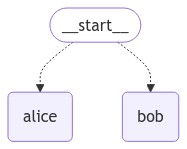

In [26]:
# rendering is naturally fucked
display(Image(graph.get_graph(xray=0).draw_mermaid_png()))

In [27]:
config = {"configurable": {"thread_id": "1"}}

for chunk in graph.stream({"messages": [("user", "hi! transfer me to bob")]}, config):
    print(chunk)
    print("\n")

{'alice': {'node': 'bob'}}


{'bob': {'messages': [HumanMessage(content="You're already speaking with Bob! How can I assist you today?", additional_kwargs={}, response_metadata={}, name='bob', id='21f83d68-d096-470e-b58e-ea1384db997e')]}}




In [28]:
for chunk in graph.stream({"messages": [("user", "who am i speaking to?")]}, config):
    print(chunk)
    print("\n")

{'bob': {'messages': [HumanMessage(content="You're speaking with Bob. How can I help you today?", additional_kwargs={}, response_metadata={}, name='bob', id='316de63d-10c2-46e3-8b99-52cfcb5b7dc4')]}}




In [29]:
for chunk in graph.stream({"messages": [("user", "what's 3 times 14?")]}, config, subgraphs=True):
    print(chunk)
    print("\n")

(('bob:4e109667-1509-91c1-ac06-1f7e04214354',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_q6LAqFkGKd4wrorqP7jksUdW', 'function': {'arguments': '{"a":3,"b":14}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 128, 'total_tokens': 145, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_831e067d82', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-3e6ba6e8-1384-4b22-83fa-a15817796384-0', tool_calls=[{'name': 'multiply', 'args': {'a': 3, 'b': 14}, 'id': 'call_q6LAqFkGKd4wrorqP7jksUdW', 'type': 'tool_call'}], usage_metadata={'input_tokens': 128, 'output_tokens': 17, 'total_tokens': 145, 'input_token_details': {'audio': 0, 'cache_r

In [30]:
for chunk in graph.stream({"messages": [("user", "cool, now transfer me back to alice")]}, config):
    print(chunk)
    print("\n")

{'bob': {'node': 'alice'}}


{'alice': {'node': 'bob'}}


{'bob': {'node': 'alice'}}


{'alice': {'node': 'bob'}}


{'bob': {'node': 'alice'}}


{'alice': {'messages': [HumanMessage(content="You're back with Alice now! How can I assist you?", additional_kwargs={}, response_metadata={}, name='alice', id='7756a85c-510a-4c91-af48-d7339657feb2')]}}




In [31]:
for chunk in graph.stream({"messages": [("user", "what's 4 + 9")]}, config, subgraphs=True):
    print(chunk)
    print("\n")

(('alice:c61fb534-0c1e-2122-c928-a664b269a4e3',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_1HqdzWmKfw2XhAQUApxUdV8r', 'function': {'arguments': '{"a":4,"b":9}', 'name': 'add'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 181, 'total_tokens': 198, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_7f6be3efb0', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-857cf747-3185-40e8-9111-395858a284c4-0', tool_calls=[{'name': 'add', 'args': {'a': 4, 'b': 9}, 'id': 'call_1HqdzWmKfw2XhAQUApxUdV8r', 'type': 'tool_call'}], usage_metadata={'input_tokens': 181, 'output_tokens': 17, 'total_tokens': 198, 'input_token_details': {'audio': 0, 'cache_read': 0}, 

In [32]:
graph.get_state(config).values["messages"]

[HumanMessage(content='hi! transfer me to bob', additional_kwargs={}, response_metadata={}, id='b3504335-8e0c-4946-99c2-d5ef6db00422'),
 HumanMessage(content="You're already speaking with Bob! How can I assist you today?", additional_kwargs={}, response_metadata={}, name='bob', id='21f83d68-d096-470e-b58e-ea1384db997e'),
 HumanMessage(content='who am i speaking to?', additional_kwargs={}, response_metadata={}, id='cf9093d6-2954-46ba-90c9-1039b5cf19f6'),
 HumanMessage(content="You're speaking with Bob. How can I help you today?", additional_kwargs={}, response_metadata={}, name='bob', id='316de63d-10c2-46e3-8b99-52cfcb5b7dc4'),
 HumanMessage(content="what's 3 times 14?", additional_kwargs={}, response_metadata={}, id='fbbd92b2-448e-44f6-aae1-2ec7ec88d067'),
 HumanMessage(content='3 times 14 is 42.', additional_kwargs={}, response_metadata={}, name='bob', id='d8a8dde6-d4f0-4ad6-b986-9008a0244242'),
 HumanMessage(content='cool, now transfer me back to alice', additional_kwargs={}, respons

---

In [162]:
builder = StateGraph(AgentRouterState)

alice = create_react_agent(
    model,
    [add, transfer_to_bob],
    state_modifier="You're Alice the cat.",
)
bob = create_react_agent(
    model,
    [multiply, transfer_to_alice, transfer_to_charlie],
    state_modifier="You're Bob the dog.",
)
charlie = create_react_agent(
    model,
    [transfer_to_bob],
    state_modifier="You're Charlie the parrot.",
)

def call_alice(state):
    response = alice.invoke(state)
    return keep_last_message_as_human(response, "alice")


def call_bob(state):
    response = bob.invoke(state)
    return keep_last_message_as_human(response, "bob")


def call_charlie(state):
    response = charlie.invoke(state)
    return keep_last_message_as_human(response, "charlie")


builder = StateGraph(AgentRouterState)
builder.add_node("alice", call_alice)
builder.add_node("bob", call_bob)
builder.add_node("charlie", call_charlie)

def router(state) -> Literal["alice", "bob", "charlie"]:
    return state.get("node", "alice")

builder.add_conditional_edges(START, router)

memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

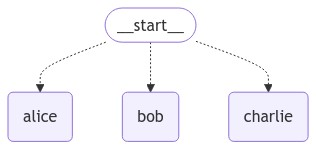

In [163]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [164]:
for chunk in graph.stream({"messages": [("user", "hi! transfer me to bob")]}, config):
    print(chunk)
    print("\n")

{'alice': {'node': 'bob'}}


{'bob': {'messages': [HumanMessage(content="I'm Bob, so you're already with me! How can I assist you today?", additional_kwargs={}, response_metadata={}, name='bob', id='fd18a3a5-8d45-475a-868f-554a2b46a643')]}}




In [165]:
for chunk in graph.stream({"messages": [("user", "transfer me to charlie")]}, config):
    print(chunk)
    print("\n")

{'bob': {'node': 'charlie'}}


{'charlie': {'messages': [HumanMessage(content="You're already with Charlie the parrot! How can I assist you today?", additional_kwargs={}, response_metadata={}, name='charlie', id='0703d459-717f-46ab-a550-57e0ee72f590')]}}




In [166]:
for chunk in graph.stream({"messages": [("user", "back to bob please")]}, config):
    print(chunk)
    print("\n")

{'charlie': {'node': 'bob'}}


{'bob': {'messages': [HumanMessage(content="I'm Bob the dog, and I'm here to help! What can I do for you today?", additional_kwargs={}, response_metadata={}, name='bob', id='fc710398-e6c4-4aa2-b429-6e0ded206a70')]}}




---

### Supervisor

In [168]:
builder = StateGraph(AgentRouterState)

supervisor = create_react_agent(
    model, 
    [transfer_to_alice, transfer_to_bob],
    state_modifier=(
        "You're team supervisor managing Alice and Bob. "
        "Alice is an expert at multiplication, Bob is great at addition. "
        "To answer user question, transfer to one of them that has the requisite skills. "
        "Once you have the final answer to user question, do not transfer -- respond to user directly!"
    )
)
bob = create_react_agent(
    model,
    [add],
    state_modifier="You're Bob the addition expert.",
)
alice = create_react_agent(
    model,
    [multiply],
    state_modifier="You're Alice the multiplication expert.",
)

def call_alice(state):
    response = alice.invoke(state)
    return keep_last_message_as_human(response, "alice")


def call_bob(state):
    response = bob.invoke(state)
    return keep_last_message_as_human(response, "bob")


builder = StateGraph(AgentRouterState)
builder.add_node("supervisor", supervisor)
builder.add_node("alice", call_alice)
builder.add_node("bob", call_bob)

builder.add_edge(START, "supervisor")
builder.add_edge("alice", "supervisor")
builder.add_edge("bob", "supervisor")

memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

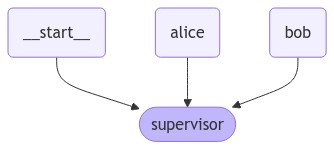

In [169]:
# graph is fucked here because there are no annotations
display(Image(graph.get_graph().draw_mermaid_png()))

In [170]:
for chunk in graph.stream({"messages": [("user", "what's 391 + 193")]}, config, subgraphs=True):
    print(chunk)
    print("\n")

(('supervisor:b8cff451-6d45-5f25-bd3d-46c9db37fe6d',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_aCbu6RvTXqKNjvuN7sjooWOF', 'function': {'arguments': '{}', 'name': 'transfer_to_bob'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 114, 'total_tokens': 126, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_7f6be3efb0', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-58f591a2-6db5-4eb2-a705-7a654d7b2e97-0', tool_calls=[{'name': 'transfer_to_bob', 'args': {}, 'id': 'call_aCbu6RvTXqKNjvuN7sjooWOF', 'type': 'tool_call'}], usage_metadata={'input_tokens': 114, 'output_tokens': 12, 'total_tokens': 126, 'input_token_details': {'audio': 0, 'cache_read': 

In [171]:
graph.get_state(config).values["messages"]

[HumanMessage(content="what's 391 + 193", additional_kwargs={}, response_metadata={}, id='c8c71ad1-c40b-4be8-bef2-efc0c5e8b30a'),
 HumanMessage(content='The sum of 391 and 193 is 584.', additional_kwargs={}, response_metadata={}, name='bob', id='8de0726b-b0f5-4564-af7b-b743185ff979'),
 AIMessage(content='The sum of 391 and 193 is 584.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 13, 'prompt_tokens': 132, 'total_tokens': 145, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_7f6be3efb0', 'finish_reason': 'stop', 'logprobs': None}, id='run-b80f2d3e-93e9-4c4b-a860-6b83f089e574-0', usage_metadata={'input_tokens': 132, 'output_tokens': 13, 'total_tokens': 145, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_d

In [172]:
graph.get_state(config).values["messages"][-1]

AIMessage(content='The sum of 391 and 193 is 584.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 13, 'prompt_tokens': 132, 'total_tokens': 145, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_7f6be3efb0', 'finish_reason': 'stop', 'logprobs': None}, id='run-b80f2d3e-93e9-4c4b-a860-6b83f089e574-0', usage_metadata={'input_tokens': 132, 'output_tokens': 13, 'total_tokens': 145, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

---

### Network

In [182]:
alice = create_react_agent(
    model_anthropic,
    [multiply, transfer_to_bob],
    state_modifier="You're Alice, a multiplication expert. You can ask Bob for help with addition."
)
bob = create_react_agent(
    model_anthropic,
    [add, transfer_to_alice],
    state_modifier="You're Bob, an addition expert. You can ask Alice for help with muiltiplication."
)

builder = StateGraph(AgentRouterState)
builder.add_node("alice", alice)
builder.add_node("bob", bob)

def router(state) -> Literal["alice", "bob"]:
    return state.get("node", "alice")

builder.add_conditional_edges(START, router)

memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

In [183]:
config = {"configurable": {"thread_id": "1"}}

In [184]:
for chunk in graph.stream({"messages": [("user", "what's 2 + 3")]}, config, subgraphs=True):
    print(chunk)

(('alice:4996eac6-85f9-6913-a2db-773262b2f68f',), {'agent': {'messages': [AIMessage(content=[{'text': 'I apologize, but as Alice the multiplication expert, I actually specialize in multiplication rather than addition. However, I can help you get that answer by asking Bob, who is good with addition. Let me transfer this question to Bob.', 'type': 'text'}, {'id': 'toolu_01Ay2uyLgcbuM8sy9d4JS2bd', 'input': {}, 'name': 'transfer_to_bob', 'type': 'tool_use'}], additional_kwargs={}, response_metadata={'id': 'msg_01LQEq28661WkgZVRRyccL6H', 'model': 'claude-3-5-sonnet-20241022', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'input_tokens': 449, 'output_tokens': 87}}, id='run-0983a50b-be70-492e-8b11-ca7459b87db4-0', tool_calls=[{'name': 'transfer_to_bob', 'args': {}, 'id': 'toolu_01Ay2uyLgcbuM8sy9d4JS2bd', 'type': 'tool_call'}], usage_metadata={'input_tokens': 449, 'output_tokens': 87, 'total_tokens': 536, 'input_token_details': {}})]}})
((), {'alice': {'node': 'bob'}})
(('bob:2d7

In [185]:
for chunk in graph.stream({"messages": [("user", "now multiply that by 11")]}, config, subgraphs=True):
    print(chunk)

(('bob:1c0e2398-691f-ad00-44fb-52d66f0938d6',), {'agent': {'messages': [AIMessage(content=[{'text': "Since I'm only an addition expert, I'll need to transfer this multiplication question to Alice who can help with multiplication.", 'type': 'text'}, {'id': 'toolu_01Lq1ucryiQMX5bv7TzhGyRV', 'input': {}, 'name': 'transfer_to_alice', 'type': 'tool_use'}], additional_kwargs={}, response_metadata={'id': 'msg_01PAJhtN22FPviZ5cW8y31NR', 'model': 'claude-3-5-sonnet-20241022', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'input_tokens': 576, 'output_tokens': 63}}, id='run-3f4a018a-6161-467a-8eab-857741ed7c23-0', tool_calls=[{'name': 'transfer_to_alice', 'args': {}, 'id': 'toolu_01Lq1ucryiQMX5bv7TzhGyRV', 'type': 'tool_call'}], usage_metadata={'input_tokens': 576, 'output_tokens': 63, 'total_tokens': 639, 'input_token_details': {}})]}})
((), {'bob': {'node': 'alice'}})
(('alice:79ee4cd6-7621-8a39-2632-4db12bd68a35',), {'agent': {'messages': [AIMessage(content=[{'text': "I'll help y

In [186]:
graph.get_state(config).values["messages"]

[HumanMessage(content="what's 2 + 3", additional_kwargs={}, response_metadata={}, id='5f0790bd-a7dc-41ec-989c-a7eb4b371f02'),
 AIMessage(content=[{'text': 'I can help you add 2 and 3 using the add function.', 'type': 'text'}, {'id': 'toolu_01GNNjqiLnJQcCLii6N1oCW9', 'input': {'a': 2, 'b': 3}, 'name': 'add', 'type': 'tool_use'}], additional_kwargs={}, response_metadata={'id': 'msg_014FRBgkLdmEpGohi55hAHRE', 'model': 'claude-3-5-sonnet-20241022', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'input_tokens': 451, 'output_tokens': 86}}, id='run-997d6867-6886-4028-8445-b077505d5c20-0', tool_calls=[{'name': 'add', 'args': {'a': 2, 'b': 3}, 'id': 'toolu_01GNNjqiLnJQcCLii6N1oCW9', 'type': 'tool_call'}], usage_metadata={'input_tokens': 451, 'output_tokens': 86, 'total_tokens': 537, 'input_token_details': {}}),
 ToolMessage(content='5', name='add', id='486dea84-1468-4c4b-9640-55139e3fc685', tool_call_id='toolu_01GNNjqiLnJQcCLii6N1oCW9'),
 AIMessage(content='The sum of 2 and 3 is 5.

In [187]:
graph.get_state(config).values["messages"][-1]

AIMessage(content='The result of 5 × 11 is 55.', additional_kwargs={}, response_metadata={'id': 'msg_014gNqBzY6NgFCUo4wTX7wEs', 'model': 'claude-3-5-sonnet-20241022', 'stop_reason': 'end_turn', 'stop_sequence': None, 'usage': {'input_tokens': 672, 'output_tokens': 18}}, id='run-5b59c305-e9dd-4d37-8ffb-32c0a0112350-0', usage_metadata={'input_tokens': 672, 'output_tokens': 18, 'total_tokens': 690, 'input_token_details': {}})

---

### Different state schema in parent vs child state

In [22]:
from langgraph.graph.message import add_messages
from langchain_core.messages import BaseMessage
from typing import Annotated, TypedDict

In [189]:
class CustomParentState(TypedDict):
    # deliberately use a different key here
    parent_messages: Annotated[list[BaseMessage], add_messages]
    node: str

In [201]:
def input_processor(state):
    return {**state, "messages": state["parent_messages"]}

def output_processor(state):
    updated_state = keep_last_message_as_human(state, None)
    return {**updated_state, "parent_messages": updated_state["messages"]}

In [202]:
alice = create_react_agent(
    model_anthropic,
    [multiply, transfer_to_bob],
    state_modifier="You're Alice, a multiplication expert. You can ask Bob for help with addition."
)
bob = create_react_agent(
    model_anthropic,
    [add, transfer_to_alice],
    state_modifier="You're Bob, an addition expert. You can ask Alice for help with muiltiplication."
)

def call_alice(state):
    response = alice.invoke(input_processor(state))
    return output_processor(response)

def call_bob(state):
    response = bob.invoke(input_processor(state))
    return output_processor(response)

builder = StateGraph(CustomParentState)
builder.add_node("alice", call_alice)
builder.add_node("bob", call_bob)

def router(state) -> Literal["alice", "bob"]:
    return state.get("node", "alice")

builder.add_conditional_edges(START, router)

memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

In [203]:
config = {"configurable": {"thread_id": "1"}}

In [204]:
for chunk in graph.stream({"parent_messages": [("user", "what's 2 + 3")]}, config, subgraphs=True):
    print(chunk)

(('alice:b8acf948-caec-090d-e583-66d694ceb731',), {'agent': {'messages': [AIMessage(content=[{'text': 'As Alice, I specialize in multiplication, not addition. Let me ask Bob for help with this addition problem.', 'type': 'text'}, {'id': 'toolu_01V1kenfacc6KX1G1prA6tMy', 'input': {}, 'name': 'transfer_to_bob', 'type': 'tool_use'}], additional_kwargs={}, response_metadata={'id': 'msg_015TxVo1WAXFvHG2fPyYDaLc', 'model': 'claude-3-5-sonnet-20241022', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'input_tokens': 449, 'output_tokens': 62}}, id='run-4273ae96-0f90-471f-b4b8-5e5e370ec5b1-0', tool_calls=[{'name': 'transfer_to_bob', 'args': {}, 'id': 'toolu_01V1kenfacc6KX1G1prA6tMy', 'type': 'tool_call'}], usage_metadata={'input_tokens': 449, 'output_tokens': 62, 'total_tokens': 511, 'input_token_details': {}})]}})
((), {'alice': {'node': 'bob'}})
(('bob:026cbecf-a6a9-a197-2163-6c61d0102c96',), {'agent': {'messages': [AIMessage(content=[{'text': 'I can help you add 2 and 3 using the

In [206]:
graph.get_state(config).values["parent_messages"]

[HumanMessage(content="what's 2 + 3", additional_kwargs={}, response_metadata={}, id='e6eb5200-b83e-4f0e-a829-576b7b02ea4f'),
 HumanMessage(content='The result of adding 2 and 3 is 5.', additional_kwargs={}, response_metadata={}, id='68479668-e5be-43cb-a884-fd3bb8e0a3f4')]

### Tools that update state (externally)

In [41]:
class CustomParentState(TypedDict):
    # deliberately use a different key here
    parent_messages: Annotated[list[BaseMessage], add_messages]
    node: str

    # this key is not available to the child graph
    user_name: str

In [42]:
from langchain_core.tools import tool

In [45]:
@tool(return_direct=True)
def get_user_name() -> GraphCommand:
    """Retrieve user name"""
    return GraphCommand(update={"user_name": "Meow"}, graph=GraphCommand.PARENT)

In [46]:
def input_processor(state):
    return {**state, "messages": state["parent_messages"]}

def output_processor(state):
    state = keep_last_message_as_human(state, None)
    return {**state, "parent_messages": state["messages"]}

In [47]:
alice = create_react_agent(model, [get_user_name])

def call_alice(state):
    response = alice.invoke(input_processor(state))
    return output_processor(response)

builder = StateGraph(CustomParentState)
builder.add_node("alice", call_alice)
builder.add_edge(START, "alice")
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

In [48]:
config = {"configurable": {"thread_id": "1"}}

In [49]:
for chunk in graph.stream({"parent_messages": [("user", "get user name")]}, config):
    print(chunk)

{'alice': {'user_name': 'Meow'}}


In [50]:
graph.get_state(config).values

{'parent_messages': [HumanMessage(content='get user name', additional_kwargs={}, response_metadata={}, id='d81197d8-7120-4d3c-9879-201dc372cd15')],
 'user_name': 'Meow'}

### Tools that update state (internally)

In [23]:
class CustomParentState(TypedDict):
    # deliberately use a different key here
    parent_messages: Annotated[list[BaseMessage], add_messages]
    node: str

In [24]:
from langgraph.prebuilt.chat_agent_executor import AgentState

In [25]:
class CustomChildState(AgentState):
    user_name: str

In [26]:
from langchain_core.tools import tool

In [27]:
@tool
def get_user_name() -> GraphCommand:
    """Retrieve user name"""
    return GraphCommand(
        update={
            "user_name": "Meow",
            "messages": [ToolMessage("Successfully retrieved user name", tool_call_id="")]
        }
    )

In [36]:
def input_processor(state):
    return {**state, "messages": state["parent_messages"]}

def output_processor(state):
    state = keep_last_message_as_human(state, None)
    return {**state, "parent_messages": state["messages"]}

In [37]:
def state_modifier(state):
    user_name = state.get("user_name")
    if user_name is None:
        return state["messages"]

    system_msg = f"User name is {user_name}"
    return [{"role": "system", "content": system_msg}] + state["messages"]

In [38]:
tools = [get_user_name, add]
alice = create_react_agent(
    # NOTE parallel tool calls = False
    model.bind_tools(tools, parallel_tool_calls=False),
    tools,
    state_schema=CustomChildState,
    state_modifier=state_modifier,
)

def call_alice(state):
    response = alice.invoke(input_processor(state))
    return output_processor(response)

builder = StateGraph(CustomParentState)
builder.add_node("alice", call_alice)
builder.add_edge(START, "alice")
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

In [39]:
config = {"configurable": {"thread_id": "1"}}

In [40]:
graph.invoke({"parent_messages": [("user", "look up my name, add 2 + 3 and respond to me by name")]}, config)

{'parent_messages': [HumanMessage(content='look up my name, add 2 + 3 and respond to me by name', additional_kwargs={}, response_metadata={}, id='fa1d54b3-d285-4750-839e-758385be7b24'),
  HumanMessage(content='Hello Meow! The sum of 2 and 3 is 5.', additional_kwargs={}, response_metadata={}, id='58a6692a-4615-462e-b30d-3ee16544fc05')]}

---

### Test interrupts from inside tools

TL;DR works w/ a single graph, doesn't work w/ subgraphs

In [49]:
from langgraph.types import interrupt, Command

In [50]:
class CustomChildState(AgentState):
    user_name: str

In [65]:
@tool
def get_user_name() -> GraphCommand:
    """Retrieve user name"""
    user_name = interrupt("Please provider user name")
    return GraphCommand(
        update={
            "user_name": user_name,
            "messages": [ToolMessage("Successfully retrieved user name", tool_call_id="")]
        }
    )

In [66]:
def state_modifier(state):
    user_name = state.get("user_name")
    if user_name is None:
        return state["messages"]

    system_msg = f"User name is {user_name}"
    return [{"role": "system", "content": system_msg}] + state["messages"]

In [73]:
checkpointer = MemorySaver()
test_agent = create_react_agent(model, [get_user_name], state_schema=CustomChildState, state_modifier=state_modifier, checkpointer=checkpointer)

builder = StateGraph(AgentState)
builder.add_node("agent", test_agent)
builder.add_edge(START, "agent")
graph = builder.compile(checkpointer=checkpointer)

In [80]:
# graph.invoke({"messages": [("user", "hi -- please get the user name")]}, config)

In [79]:
# graph.get_state(config).tasks

In [78]:
# graph.invoke(Command(resume="Archibald"), config)

In [71]:
test_agent.invoke({"messages": [("user", "whats my name")]}, config)

{'messages': [HumanMessage(content='whats my name', additional_kwargs={}, response_metadata={}, id='e0a178b7-a404-438f-a287-b8bd8a500797'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_0r1Vh3GBJTwMM2fwoZ30iugA', 'function': {'arguments': '{}', 'name': 'get_user_name'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 40, 'total_tokens': 51, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_831e067d82', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-929add1e-1d46-48f0-855c-472390ad0cf7-0', tool_calls=[{'name': 'get_user_name', 'args': {}, 'id': 'call_0r1Vh3GBJTwMM2fwoZ30iugA', 'type': 'tool_call'}], usage_metadata={'input_tokens': 40, 'output_tokens': 11, 'total_tokens':

In [72]:
test_agent.invoke(Command(resume="Archibald"), config)

{'messages': [HumanMessage(content='whats my name', additional_kwargs={}, response_metadata={}, id='e0a178b7-a404-438f-a287-b8bd8a500797'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_0r1Vh3GBJTwMM2fwoZ30iugA', 'function': {'arguments': '{}', 'name': 'get_user_name'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 40, 'total_tokens': 51, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_831e067d82', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-929add1e-1d46-48f0-855c-472390ad0cf7-0', tool_calls=[{'name': 'get_user_name', 'args': {}, 'id': 'call_0r1Vh3GBJTwMM2fwoZ30iugA', 'type': 'tool_call'}], usage_metadata={'input_tokens': 40, 'output_tokens': 11, 'total_tokens':

---